## Unsupervised Domain Adaptation on Amazon Review Dataset

**Author**: Medha Agarwal 

**Last modified**: 03/03/2024

In this notebook, we use normalizing flows for unconstrained domain adaptation of Amazon reviews dataset. In this setting, the source domain is denoted by $\mathcal{S} = (\mathcal{X}_S, \mathcal{C})$ where $\mathcal{X}_S$ is the domain of source features and $\mathcal{C}$ is the space of classes. Similarly, $\mathcal{T} = (\mathcal{X}_T, \mathcal{C})$ is the target domain. Define the random variables $(X_S, Y_S)$ on $\mathcal{S}$ where $X_S$ is the random variable denoting source covariates and $Y_S$ are source labels. Similarly $(X_T,Y_T)$ denotes similar quantities for the target domain. In an unsupervised domain adaptation setting, we have labelled samples from the source domain, denoted by $\mathcal{D}_S = \{(x_i^S, y_i^S)\}_{i=1}^{n_S}$ and unlabelled samples from the target domain denoted by $\mathcal{D}_T = \{x_i^T\}_{i=1}^{n_T}$. The goal is to learn a classifier $\hat f_T: \mathcal{X}_T \to \mathcal{C}$ using only $\mathcal{D}_S$ and $\mathcal{D}_T$. In this notebook, this problem is solved via the following string of operations:

1. Finetune the BERT model on a subset of 10,000 samples from the WILDS Amazon Reviews benchmark dataset with the empirical risk minimization objective.
2. Apply the network to another held-out training sample of 10,000 examples from one domain, as well as validation and test sets of size 10,000 each from another domain.
3. Apply PCA on train covariates for dimension reduction.
3. Use the penultimate layer of the network outputs to generate frozen feature representations of the train, validation, and test sets described above.
4. Learn a diffeomorphism between the empirical distribution of training covariates and Gaussian distribution. 
5. Learn another diffeomorphism between the empirical distribution of test and validation covariates and Gaussian distribution. 

In [1]:
%%capture

!pip install wilds
!pip install transformers

In [1]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm import tqdm
import datetime
import time
import random
import pickle
import os


from matplotlib import pyplot as plt

from normalizing_flow import MAF, MADE
from utils import (format_time,
                    train_one_epoch_maf,
                    train_one_epoch_made,
                    test_maf, test_made,
                    val_maf, val_made)
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset
from sklearn.metrics import accuracy_score

Let us load the embeddings of train and test dataset into memory.

In [2]:
DATASET_PATH = '/mnt/ssd/medhaaga/CSE599/data'
EPOCHS = 200
BATCH_SIZE = 64
dataset = "amazon_data"
os.makedirs(os.path.join(DATASET_PATH, f"{dataset}"), exist_ok=True)

X_train_source = np.load(os.path.join(DATASET_PATH, f"{dataset}/x_train_source.npy"))
y_train_source = np.load(os.path.join(DATASET_PATH, f"{dataset}/y_train_source.npy"))

X_train_target = np.load(os.path.join(DATASET_PATH, f"{dataset}/x_train_target.npy"))
y_train_target = np.load(os.path.join(DATASET_PATH, f"{dataset}/y_train_target.npy"))

X_test_source = np.load(os.path.join(DATASET_PATH, f"{dataset}/x_test_source.npy"))
y_test_source = np.load(os.path.join(DATASET_PATH, f"{dataset}/y_test_source.npy"))

X_test_target = np.load(os.path.join(DATASET_PATH, f"{dataset}/x_test_target.npy"))
y_test_target = np.load(os.path.join(DATASET_PATH, f"{dataset}/y_test_target.npy"))

print(X_train_source.shape, X_test_source.shape)
print(X_train_target.shape, X_test_target.shape)


(5000, 16) (2500, 16)
(5000, 16) (2500, 16)


Let us standardize the features for efficient transfer to Gaussian distribution later.

In [3]:
X_train_source = (X_train_source - np.mean(X_train_source, axis=0, keepdims=True))/np.std(X_train_source, axis=0, keepdims=True)
X_train_target = (X_train_target - np.mean(X_train_target, axis=0, keepdims=True))/np.std(X_train_target, axis=0, keepdims=True)
X_test_source = (X_test_source - np.mean(X_test_source, axis=0, keepdims=True))/np.std(X_test_source, axis=0, keepdims=True)
X_test_target = (X_test_target - np.mean(X_test_target, axis=0, keepdims=True))/np.std(X_test_target, axis=0, keepdims=True)

In [4]:
train_source_dataset = TensorDataset(torch.Tensor(X_train_source), torch.Tensor(y_train_source).to(torch.long))
train_target_dataset = TensorDataset(torch.Tensor(X_train_target), torch.Tensor(y_train_target).to(torch.long))
test_source_dataset = TensorDataset(torch.Tensor(X_test_source), torch.Tensor(y_test_source).to(torch.long))
test_target_dataset = TensorDataset(torch.Tensor(X_test_target), torch.Tensor(y_test_target).to(torch.long))

In [5]:
train_source_loader = torch.utils.data.DataLoader(train_source_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_target_loader = torch.utils.data.DataLoader(train_target_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_source_loader = torch.utils.data.DataLoader(test_source_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_target_loader = torch.utils.data.DataLoader(test_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Learn a classifier on source data

In [6]:
class TextClassificationModel(nn.Module):
    def __init__(self, embedding_size, hidden_size=32):

        super(TextClassificationModel, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [7]:
# Function for training the model
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = (outputs >= 0.5)
        correct_predictions += (predictions == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy


In [8]:
# Function for evaluating the model
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            running_loss += loss.item()
            predictions = (outputs >= 0.5)
            correct_predictions += (predictions == labels.unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, accuracy

In [9]:
embedding_size = X_train_source.shape[1]

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassificationModel(embedding_size, hidden_size=64)
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
best_test_accuracy = 0

for epoch in tqdm(range(200)):

    train_loss, train_accuracy = train(model, train_source_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, test_source_loader, criterion, device)

    if val_accuracy > best_test_accuracy:
        torch.save(model, 'results/classifier.pt')

    if epoch == 0 or (epoch+1) % 50 == 0:

        print(f'Epoch {epoch + 1}/{200} - '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - '
            f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

  1%|          | 2/200 [00:00<00:39,  5.04it/s]

Epoch 1/200 - Train Loss: 0.6376, Train Accuracy: 0.6546 - Validation Loss: 0.5869, Validation Accuracy: 0.7160


 26%|██▌       | 51/200 [00:07<00:20,  7.19it/s]

Epoch 50/200 - Train Loss: 0.4746, Train Accuracy: 0.7722 - Validation Loss: 0.5284, Validation Accuracy: 0.7316


 50%|█████     | 101/200 [00:15<00:13,  7.20it/s]

Epoch 100/200 - Train Loss: 0.4507, Train Accuracy: 0.7906 - Validation Loss: 0.5434, Validation Accuracy: 0.7200


 76%|███████▌  | 151/200 [00:22<00:06,  7.16it/s]

Epoch 150/200 - Train Loss: 0.4400, Train Accuracy: 0.7956 - Validation Loss: 0.5544, Validation Accuracy: 0.7156


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]

Epoch 200/200 - Train Loss: 0.4204, Train Accuracy: 0.8094 - Validation Loss: 0.5754, Validation Accuracy: 0.7164


Now let us calculate the prediction accuracy of the model (trained on source data) on the target data.


In [11]:
classifier = torch.load('results/classifier.pt')
train_loss, train_accuracy = evaluate(model, train_source_loader, criterion, device)
print(f'Source train Loss: {train_loss:.4f}, Source train Accuracy: {train_accuracy:.4f}')

test_loss, test_accuracy = evaluate(model, test_source_loader, criterion, device)
print(f'Source test Loss: {test_loss:.4f}, Source Accuracy: {test_accuracy:.4f}')

val_loss, val_accuracy = evaluate(model, test_target_loader, criterion, device)
print(f'Target test Loss: {val_loss:.4f}, Target Accuracy: {val_accuracy:.4f}')

Source train Loss: 0.4140, Source train Accuracy: 0.8150
Source test Loss: 0.5705, Source Accuracy: 0.7164
Target test Loss: 0.6727, Target Accuracy: 0.6612


## Learn Normalizing Flows from Source and Target Distribution

### Source Distribution -> Normal Distribution

Set training parameters

In [30]:
n_mades = 3
hidden_dims = [8]
lr = 1e-4
weight_decay = 1e-4
random_order = False
patience = 500
seed = 0
model_name = 'maf'
epochs = 100

In [31]:
n_in = X_train_source.shape[1]

if model_name.lower() == "maf":
    source_flow = MAF(n_in, n_mades, hidden_dims)
elif model_name.lower() == "made":
    source_flow = MADE(n_in, hidden_dims, random_order=random_order, seed=seed, gaussian=True)

optimiser = torch.optim.Adam(source_flow.parameters(), lr=lr, weight_decay=weight_decay)
save_dir = f'results/{model_name}'
os.makedirs(save_dir, exist_ok=True)
save_name = os.path.join(save_dir, 'source_flow.pt')

In [32]:
train_losses, val_losses = [], []
max_loss = np.inf

print("Training...")
t0 = time.time()
for epoch_i in tqdm(range(epochs)):

    if model_name == "maf":
        train_loss = train_one_epoch_maf(source_flow, optimiser, train_source_loader)
        val_loss = val_maf(source_flow, test_source_loader)
    elif model_name == "made":
        train_loss = train_one_epoch_made(source_flow, optimiser, train_source_loader)
        val_loss = val_made(source_flow, test_source_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch_i+1) % 10 == 0:
        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
        print(f"Training and validation takes: {format_time(time.time() - t0)}.")
        print("")
        print(f"Average train loss: {train_loss}")
        print(f"Average validation loss: {val_loss}")

    if val_loss < max_loss:
        i = 0
        max_loss = val_loss
        torch.save(
            source_flow, save_name
        )  
    else:
        i += 1

    if i >= patience:
        print("Patience counter: {}/{}\n Terminate training!".format(i, patience))
        break

print("Training complete!")
print(f"Took {format_time(time.time() - t0)}.")



Training...


 10%|█         | 10/100 [00:03<00:29,  3.04it/s]


======== Epoch 10 / 100 ========
Training and validation takes: 0:00:03.

Average train loss: 21.99181846425503
Average validation loss: 22.385190132904054


 20%|██        | 20/100 [00:06<00:26,  3.07it/s]


======== Epoch 20 / 100 ========
Training and validation takes: 0:00:07.

Average train loss: 21.009304143205473
Average validation loss: 21.453550407791138


 30%|███       | 30/100 [00:09<00:23,  2.99it/s]


======== Epoch 30 / 100 ========
Training and validation takes: 0:00:10.

Average train loss: 19.434695400769197
Average validation loss: 19.972150650787352


 40%|████      | 40/100 [00:13<00:19,  3.09it/s]


======== Epoch 40 / 100 ========
Training and validation takes: 0:00:13.

Average train loss: 16.20789303357088
Average validation loss: 16.62827237739563


 50%|█████     | 50/100 [00:16<00:16,  3.07it/s]


======== Epoch 50 / 100 ========
Training and validation takes: 0:00:16.

Average train loss: 12.203410426272622
Average validation loss: 13.667342945480346


 60%|██████    | 60/100 [00:19<00:13,  3.01it/s]


======== Epoch 60 / 100 ========
Training and validation takes: 0:00:20.

Average train loss: 4.292958567414103
Average validation loss: 5.799036517333985


 70%|███████   | 70/100 [00:22<00:09,  3.06it/s]


======== Epoch 70 / 100 ========
Training and validation takes: 0:00:23.

Average train loss: -2.3934376601931415
Average validation loss: -1.5262059562683106


 80%|████████  | 80/100 [00:26<00:06,  3.08it/s]


======== Epoch 80 / 100 ========
Training and validation takes: 0:00:26.

Average train loss: -11.464384579960305
Average validation loss: 0.8090283126831055


 90%|█████████ | 90/100 [00:29<00:03,  3.09it/s]


======== Epoch 90 / 100 ========
Training and validation takes: 0:00:29.

Average train loss: -18.653248050544835
Average validation loss: 6.568806925201416


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


======== Epoch 100 / 100 ========
Training and validation takes: 0:00:33.

Average train loss: -23.901557294628287
Average validation loss: 12.185913510131837
Training complete!
Took 0:00:33.


### Target Distribution -> Normal Distribution

In [33]:
n_in = X_train_target.shape[1]

if model_name.lower() == "maf":
    target_flow = MAF(n_in, n_mades, hidden_dims)
elif model_name.lower() == "made":
    target_flow = MADE(n_in, hidden_dims, random_order=random_order, seed=seed, gaussian=True)

optimiser = torch.optim.Adam(target_flow.parameters(), lr=lr, weight_decay=weight_decay)
save_dir = f'results/{model_name}'
os.makedirs(save_dir, exist_ok=True)
save_name = os.path.join(save_dir, 'target_flow.pt')

In [41]:
train_losses, val_losses = [], []
max_loss = np.inf

print("Training...")
t0 = time.time()
for epoch_i in tqdm(range(epochs)):

    if model_name == "maf":
        train_loss = train_one_epoch_maf(target_flow, optimiser, train_target_loader)
        val_loss = val_maf(target_flow, test_target_loader)
    elif model_name == "made":
        train_loss = train_one_epoch_made(target_flow, optimiser, train_target_loader)
        val_loss = val_made(target_flow, test_target_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch_i+1) % 10 == 0:

        print("")
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
        print(f"Training and validation takes: {format_time(time.time() - t0)}.")
        print("")
        print(f"Average train loss: {train_loss}")
        print(f"Average validation loss: {val_loss}")

    if val_loss < max_loss:
        i = 0
        max_loss = val_loss
        torch.save(
            target_flow, save_name
        )  
    else:
        i += 1

    if i >= patience:
        print("Patience counter: {}/{}\n Terminate training!".format(i, patience))
        break

print("Training complete!")
print(f"Took {format_time(time.time() - t0)}.")



Training...


 10%|█         | 10/100 [00:02<00:24,  3.73it/s]


======== Epoch 10 / 100 ========
Training and validation takes: 0:00:03.

Average train loss: -31.935440932648092
Average validation loss: 914.3177624565125


 20%|██        | 20/100 [00:05<00:21,  3.78it/s]


======== Epoch 20 / 100 ========
Training and validation takes: 0:00:05.

Average train loss: -31.913618546497972
Average validation loss: -14.22830612411499


 26%|██▌       | 26/100 [00:07<00:20,  3.61it/s]


KeyboardInterrupt: 

Now let us normalize the test source and target data.

In [43]:
X_test_source = torch.Tensor(X_test_source)
X_test_target = torch.Tensor(X_test_target)

with torch.no_grad():
    normalized_X_test_source, _ = source_flow(X_test_source)
    normalized_X_test_target, _ = source_flow(X_test_target)

print(normalized_X_test_source.shape, normalized_X_test_target.shape)

torch.Size([2500, 16]) torch.Size([2500, 16])


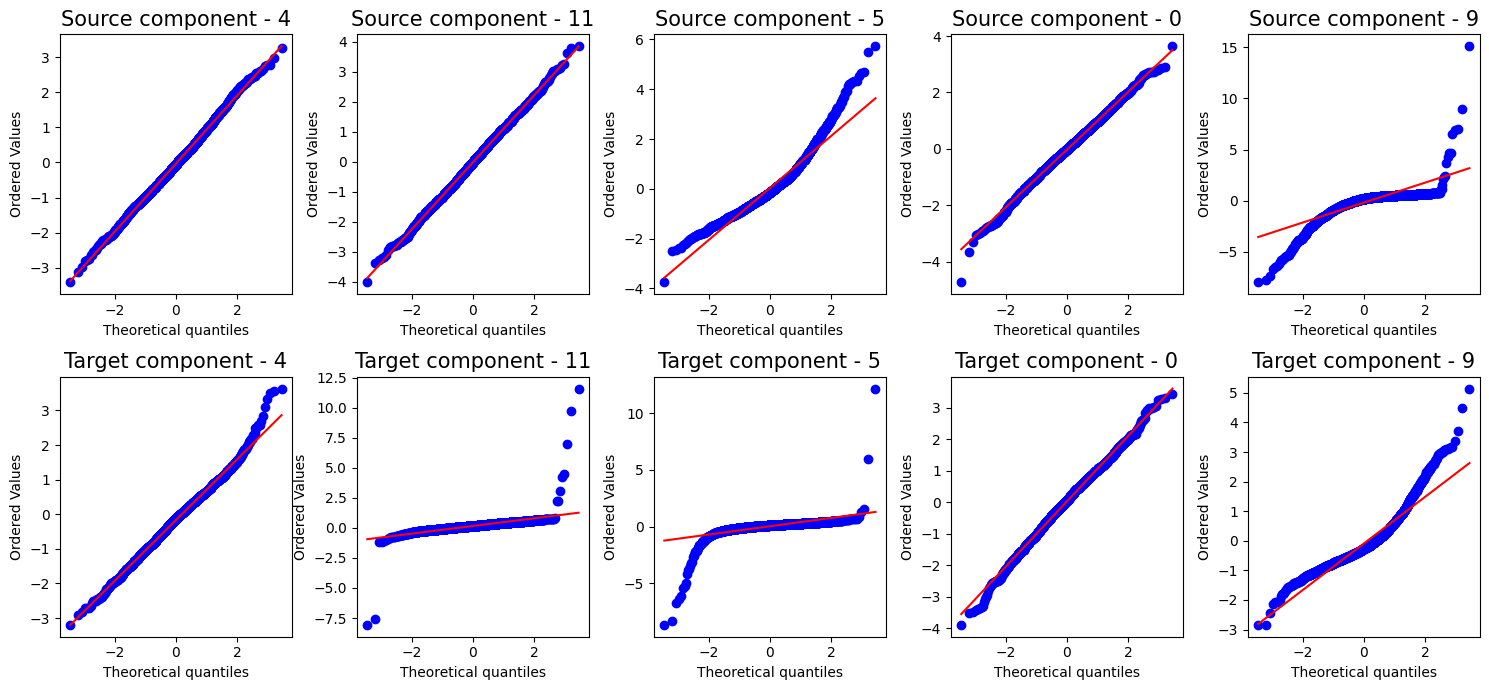

In [69]:
from scipy import stats

comps = np.random.choice(normalized_X_test_source.shape[1], 5, replace=False) 

# Create subplots for multiple Q-Q plots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for i,c in enumerate(comps):

    stats.probplot(normalized_X_test_source[:,c], dist="norm", plot=axes[0,i])
    axes[0,i].set_title(f'Source component - {c}', fontsize=15)

for i,c in enumerate(comps):

    stats.probplot(normalized_X_test_target[:,c], dist="norm", plot=axes[1,i])
    axes[1,i].set_title(f'Target component - {c}', fontsize=15)


plt.tight_layout()
plt.show()


Now let us check if transporting the source distribution to target distribution improves the prediction accuracy using the classifier learned on the source data.

In [58]:
source_flow = torch.load('results/maf/source_flow.pt')
target_flow = torch.load('results/maf/target_flow.pt')
classifier = torch.load('results/classifier.pt').to('cpu')
criterion = nn.BCELoss()


with torch.no_grad():
    normalized_X_test_target, _ = target_flow(X_test_target)
    transpoted_X_test_target, _ = source_flow.backward(normalized_X_test_target)


In [59]:
with torch.no_grad():
    outputs = classifier(X_test_source)
    loss = criterion(outputs, torch.tensor(y_test_source).unsqueeze(1).float())

predictions = (outputs >= 0.5)
correct_predictions = (predictions == torch.tensor(y_test_source).unsqueeze(1)).sum().item()/y_test_source.shape[0]
print(f'Predictions on source test data using classifier trained on source data:')
print(f'Loss: {loss.item()}, Accuracy: {correct_predictions}')

with torch.no_grad():
    outputs = classifier(X_test_target)
    loss = criterion(outputs, torch.tensor(y_test_target).unsqueeze(1).float())

predictions = (outputs >= 0.5)
correct_predictions = (predictions == torch.tensor(y_test_target).unsqueeze(1)).sum().item()/y_test_target.shape[0]
print(f'\nPredictions on target test data using classifier trained on source data:')
print(f'Loss: {loss.item()}, Accuracy: {correct_predictions}')

Predictions on source test data using classifier trained on source data:
Loss: 0.5657579302787781, Accuracy: 0.7164

Predictions on target test data using classifier trained on source data:
Loss: 0.6749739050865173, Accuracy: 0.6612


In [60]:
with torch.no_grad():
    outputs = classifier(transpoted_X_test_target)
    loss = criterion(outputs, torch.tensor(y_test_target).unsqueeze(1).float())

predictions = (outputs >= 0.5)
correct_predictions = (predictions == torch.tensor(y_test_target).unsqueeze(1)).sum().item()/y_test_target.shape[0]
print(f'Predictions on target test data using transported target data:\n')
print(f'Loss: {loss.item()}, Accuracy: {correct_predictions}')

Predictions on target test data using transported target data:

Loss: 0.6959940195083618, Accuracy: 0.5712
